# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [2]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
#frequency table for prestige and whether or not someone was admitted
#pd.crosstab([df['admit'],df['prestige']],[df['gpa']])

pd.crosstab(df['admit'],[df['prestige']]).apply(lambda x: x/sum(x))


prestige,1.0,2.0,3.0,4.0
admit,,,,
0,0.459016,0.641892,0.768595,0.820896
1,0.540984,0.358108,0.231405,0.179104


Explanation: In the frequency table we are are basically counting the number of observations on the unique columns of the Dataframe.  In this case we have an admit column and a prestige column and both are categorical variables as we verified in the previous unit projects. For each admit category AND each prestige category, we want to tabulate the number of observations for each combination of categories.  I will do this using Pandas "crosstab" function.  There is an 'index' argument and a 'column' argument. The index argument says "values to group-by in the rows". The rows refer to the tabulated table rows (admit in the example above). We want admit to be the rows, so I pass in the admit column of the Dataframe like this: df['admit']. The crosstab function will know to group all the 1 observations together and the 0 observations together. Then in the column argument to crosstab,I can pass in the prestige data. Crosstab will take the groups of admit = 1 and 0 and further segment those groups by prestige levels and just do a simple count of how many obeservations are in each.

In [4]:
stats=df.groupby('admit').mean()
stats['Stat']='Mean'
stats=stats.append(df.groupby('admit').std())
stats.fillna('Std')

,Stat,gpa,gre,prestige
admit,,,,
0,Mean,3.347159,573.579336,2.645756
1,Mean,3.489206,618.571429,2.150794
0,Std,0.376355,116.052798,0.918922
1,Std,0.371655,109.257233,0.921455


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [5]:
dummyPrestige = pd.get_dummies(df['prestige'],prefix='prestige')
dummyPrestige

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1
5,0,1,0,0
6,1,0,0,0
7,0,1,0,0
8,0,0,1,0
9,0,1,0,0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: Since prestige is the only categorical variable (GRE is discrete and GPA is continuous), we only need dummy variables for prestige.  Each dummy variable column is dichotomous and there are four ranks (1-4).  When creating dummy variables we set a baseline, which is typically the variable with the most occurances.  Therefore we need three additional dummy_presitige variables since we drop one of the dummy variables to avoid redundant information.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [6]:
columnsToKeep = ['admit', 'gre', 'gpa']
handCalcDf = df[columnsToKeep].join(dummyPrestige.ix[:, 'prestige_1.0':])
handCalcDf.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


In [7]:
#crosstab prestige_1.0 admission 
#frequency table cutting prestige and whether or not someone was admitted
#column 0 indicates all other schools not in prestige_1.0

pd.crosstab(handCalcDf['admit'],[handCalcDf['prestige_1.0']])

prestige_1.0,0,1
admit,,
0,243,28
1,93,33


Explanation: When prestige_1.0 students are evaluated, 33 were admitted, and 28 were not. Amongst all other students who did not attend prestige_1.0), 93 were admitted and 243 were not.

#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [8]:
#Prob = P(admitted in prestige_1.0)
#prob = float(33)/61*100
#Odds = P(something happening) / P(something not happening)
#total students in prestige_1.0 = 33+28 = 61

oddsA = float(33)/28
print oddsA

1.17857142857


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [9]:
oddsB = float(93)/243
print oddsB

0.382716049383


#### 3.3 Calculate the odds ratio

In [10]:
OR = oddsA/oddsB
print OR

3.07949308756


#### 3.4 Write this finding in a sentenance: 

Answer: The odds ratio here tells us that the odds of admission are approximately 300% higher (Odds Ratio x 100%) for students who went to a prestige_1.0 school than they are for students who did not go to a prestige_1.0 school.  I.e. for students who attended a prestige_1.0 school, the odds of being admitted into the graduate program are 3.08 times the odds of studens who did not attend a prestige_1.0 school.

#### 3.5 Print the cross tab for prestige_4

In [11]:
pd.crosstab(handCalcDf['admit'],[handCalcDf['prestige_4.0']])

prestige_4.0,0,1
admit,,
0,216,55
1,114,12


#### 3.6 Calculate the OR 

In [12]:
#odds of admission if you attended a #4 ranked college
oddsC = float(12)/55

#odds of admission if you did not attend a #4 ranked college
oddsD = float(114)/216

OR = oddsC/oddsD
print OR
1-OR

0.413397129187


0.5866028708133972

#### 3.7 Write this finding in a sentence

Answer: The odds ratio here tells us that the odds of admission are approximately 59% lower for students who went to a prestige_4.0 school than they are for students who did not go to a prestige_4.0 school.  

## Part 4. Analysis

In [13]:
#create a clean data frame for the regression
#we only keep prestige_2, prestige_3, and prestige_4 because we do not want redundant information in our variables

columnsToKeep = ['admit', 'gre', 'gpa']
data = df[columnsToKeep].join(dummyPrestige.ix[:, 'prestige_2.0':])
data.head()

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,1,0
1,1,660.0,3.67,0,1,0
2,1,800.0,4.00,0,0,0
3,1,640.0,3.19,0,0,1
4,0,520.0,2.93,0,0,1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [14]:
#manually add the intercept if using statsmodels
data['intercept'] = 1.0

Explanation:  Adding an intercept column of all 1.0's actually represents an intercept term in the regression because if one of the predictors is always 1.0, its Beta value will be one (i.e. no change on overall results), and so it effectively just adds 1.0 to the regression = the intercept.

#### 4.1 Set the covariates to a variable called train_cols

In [15]:
#These are essentially our X values
#train_cols = ['gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0','intercept']

train_cols_stats = data.ix[:,1:]
print train_cols_stats.head()

train_cols = data.ix[:,1:6]
print train_cols.head()

     gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0  intercept
0  380.0  3.61             0             1             0        1.0
1  660.0  3.67             0             1             0        1.0
2  800.0  4.00             0             0             0        1.0
3  640.0  3.19             0             0             1        1.0
4  520.0  2.93             0             0             1        1.0
     gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0  380.0  3.61             0             1             0
1  660.0  3.67             0             1             0
2  800.0  4.00             0             0             0
3  640.0  3.19             0             0             1
4  520.0  2.93             0             0             1


#### 4.2 Fit the model

In [16]:
#logistic regression using statsmodels
#MLE = maximum likelihood estimate

logModel = sm.Logit(data['admit'],train_cols_stats)
resultFitStat = logModel.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


Explanation: Model fitting is a procedure that can be summarized in three steps...
(1) First you need a function that takes in a set of parameters and returns a predicted data set.
(2) Second you need an 'error function' that provides a number representing the difference between your data and the model's prediction for any given set of model parameters. This is usually either the sums of squared error (SSE) or maximum likelihood.
(3) Third you need to find the parameters that minimize this difference.
The fit process here involves two steps...
(1) Create a Logit object passing in the correct arguments. "endog" is the dependent variable according to the documentation and "exog" is the independent variables. 
(2) Fit the model as described in the documentation: http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.discrete.discrete_model.Logit.html

In [17]:
#statsmodels results

summary = resultFitStat.summary()
print summary

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Wed, 01 Feb 2017   Pseudo R-squ.:                 0.08166
Time:                        15:29:03   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2.0    -0.6801      0.317     -2.14

In [18]:
#logistic regression using sklearn

import sklearn.linear_model as lm

logModel = lm.LogisticRegression()
resultFit = logModel.fit(train_cols,data['admit'])

In [19]:
#sklearn results

print resultFit.coef_
print resultFit.intercept_
print df.admit.mean()

[[ 0.00178497  0.23229458 -0.60347467 -1.17214957 -1.37729795]]
[-1.81701706]
0.317380352645


#### 4.3 Print the summary results

In [55]:
#calculating the accuracy with sklearn

from sklearn.metrics import accuracy_score

X = train_cols
y = df['admit']

predicted = resultFit.predict(X)
threshold = 0.5
predictedClasses = (predicted > threshold).astype(int)
print accuracy_score(y, predictedClasses)

predictedProba1 = resultFit.predict_proba(X)
predictedProba2 = predictedProba1[:,1]
print predictedProba2

print predictedClasses

0.705289672544
[ 0.18659419  0.27716576  0.63184466  0.21233404  0.17001703  0.40925899
  0.46874205  0.27070755  0.22481859  0.43526125  0.3021334   0.42956137
  0.61508543  0.38804338  0.58943772  0.2086162   0.28842267  0.14780737
  0.4696848   0.50797682  0.20419042  0.40150911  0.18720704  0.2245205
  0.42905043  0.61328896  0.53201833  0.19823728  0.43039855  0.46889457
  0.20548533  0.2985104   0.24445981  0.3470547   0.39054492  0.26933392
  0.49330638  0.19983482  0.30982793  0.1917883   0.29759959  0.35114953
  0.35028634  0.20952587  0.38034939  0.20315947  0.35859467  0.16632301
  0.13790066  0.18287472  0.27885915  0.15685126  0.2515047   0.39004865
  0.26207308  0.32319895  0.22294903  0.16411395  0.29762611  0.18720704
  0.36005798  0.19411147  0.27007075  0.29295988  0.26411199  0.37388842
  0.26259399  0.51405567  0.51884944  0.61713824  0.28544585  0.12126306
  0.17507905  0.38792808  0.24829637  0.31543981  0.22986517  0.3470547
  0.46795069  0.55449361  0.21905523  

In [21]:
#k-folds cross validation with sklearn

from sklearn.cross_validation import KFold, cross_val_score

scores = cross_val_score(resultFit,train_cols, data.admit, cv=5)
print scores  

#kf = KFold(4, n_folds=2)
#mylist = list(kf)
#train, test = mylist[0]
#for train_index, test_index in kf:
 #   print("TRAIN:", train_index, "TEST:", test_index)

[ 0.7037037   0.73417722  0.70886076  0.67088608  0.69620253]


Explanation:

See above. The confidence interval is the lower and upper range for the distribution of coefficients for each variable.  The confidence interval contains the parameter values that, when tested, should not be rejected with the same sample.  Confidence intervals of difference parameters not containing 0 imply that there is a statistically significant difference between the populations.  Therefore, the significant predictors are the prestige categories and the GPA (somewhat of a strong predictor), but GRE is not.  The coefficients represent the Beta values for the fit function.  From the summary printed above, we can see that there is an inverse relationship between the probability of admission and the prestige of the school.  Thus, the probability of admission is higher for students who attended a top ranked prestigue_1.0 school.  

Sklearn tells us that he accuracy of the model with all features (removing one rank) is about 70%.  I then performed k-folds and found that the accuracy is roughly 70% across all five folds.  The goal is to get your accuracy score consistent accross all of your folds.

0.565439582967


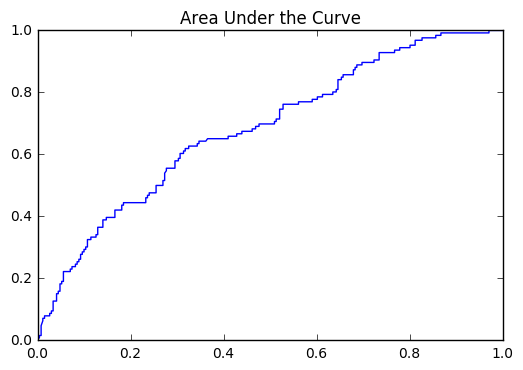

In [61]:
from sklearn import dummy, metrics

ax = plt.subplot(111)
vals = metrics.roc_curve(df.admit,predictedProba2)
ax.plot(vals[0], vals[1])
ax.set(title='Area Under the Curve', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

AUC = metrics.roc_auc_score(df.admit, predictedClasses)
print AUC

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [22]:
#using Statsmodels
resultFitStat.conf_int()

,0,1
gre,0.000074,0.004362
gpa,0.127619,1.431056
prestige_2.0,-1.301337,-0.058936
prestige_3.0,-2.014579,-0.662776
prestige_4.0,-2.371624,-0.735197
intercept,-6.116077,-1.637631


In [23]:
#We can easily convert these into odds using numpy.exp()

np.exp(resultFitStat.params)

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64

In [24]:
params = resultFitStat.params
conf = resultFitStat.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
gre,1.000074,1.004372,1.002221
gpa,1.136120,4.183113,2.180027
prestige_2.0,0.272168,0.942767,0.506548
prestige_3.0,0.133377,0.515419,0.262192
prestige_4.0,0.093329,0.479411,0.211525
intercept,0.002207,0.194440,0.020716


#### 4.5 Interpret the OR of Prestige_2

In [25]:
data['prestige_2.0'].describe()

count    397.000000
mean       0.372796
std        0.484159
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: prestige_2.0, dtype: float64

Answer: From the OR generated above, we can see that the odds of admission decreases 50% if a student goes to a prestige_2.0 school (as compared to the baseline prestige_1.0 school).

#### 4.6 Interpret the OR of GPA

In [26]:
data['gpa'].describe()

count    397.000000
mean       3.392242
std        0.380208
min        2.260000
25%        3.130000
50%        3.400000
75%        3.670000
max        4.000000
Name: gpa, dtype: float64

Answer: The odds ratio here tells us that the odds of admission are approximately 218% higher (Odds Ratio x 100%) for every one-unit increase in GPA (e.g. from 3.0 to 4.0)

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [27]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [28]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [29]:
#here we won't know what actually happened because we do not have an 'admit' column
#so we cannot make a confusion matrix
#the purpose here is how to predict against my original model

In [30]:
#recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_prestige2 = pd.get_dummies(combos['prestige'],prefix = 'prestige')
dummy_prestige2.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']

#keep only what we need for making predictions
columnsToKeep2 = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[columnsToKeep2].join(dummy_prestige2.ix[:, 'prestige_2.0':])

In [31]:
combos.head()
combos.shape

(400, 7)

#### 5.2 Make predictions on the enumerated dataset

In [32]:
train_cols_new = combos[['gre', 'gpa', 'prestige_2.0', 'prestige_3.0','prestige_4.0']]
train_cols_new.head()

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,0,0,0
1,220.0,2.260000,1,0,0
2,220.0,2.260000,0,1,0
3,220.0,2.260000,0,0,1
4,220.0,2.453333,0,0,0


In [33]:
type(train_cols_new)
train_cols_new.shape

(400, 5)

In [34]:
train_cols_new.count()

gre             400
gpa             400
prestige_2.0    400
prestige_3.0    400
prestige_4.0    400
dtype: int64

In [35]:
#this prints out two columns, one with probabilty of 1 and one with the probability of 0
a = resultFit.predict_proba(train_cols_new)
print a

[[ 0.71081335  0.28918665]
 [ 0.81799353  0.18200647]
 [ 0.88810083  0.11189917]
 [ 0.90692343  0.09307657]
 [ 0.70149503  0.29850497]
 [ 0.81121157  0.18878843]
 [ 0.88355936  0.11644064]
 [ 0.90306249  0.09693751]
 [ 0.69200656  0.30799344]
 [ 0.80423738  0.19576262]
 [ 0.8788587   0.1211413 ]
 [ 0.89905922  0.10094078]
 [ 0.68235306  0.31764694]
 [ 0.79706999  0.20293001]
 [ 0.87399535  0.12600465]
 [ 0.89490987  0.10509013]
 [ 0.67254016  0.32745984]
 [ 0.78970881  0.21029119]
 [ 0.86896586  0.13103414]
 [ 0.8906107   0.1093893 ]
 [ 0.66257402  0.33742598]
 [ 0.78215358  0.21784642]
 [ 0.86376691  0.13623309]
 [ 0.88615803  0.11384197]
 [ 0.65246131  0.34753869]
 [ 0.77440445  0.22559555]
 [ 0.85839531  0.14160469]
 [ 0.88154822  0.11845178]
 [ 0.64220917  0.35779083]
 [ 0.76646198  0.23353802]
 [ 0.85284798  0.14715202]
 [ 0.8767777   0.1232223 ]
 [ 0.63182527  0.36817473]
 [ 0.75832715  0.24167285]
 [ 0.84712204  0.15287796]
 [ 0.87184299  0.12815701]
 [ 0.6213177   0.3786823 ]
 

In [36]:
combos['predict_admit'] = a[:,1:]
combos.head()

,gre,gpa,prestige,intercept,prestige_2.0,prestige_3.0,prestige_4.0,predict_admit
0,220.0,2.260000,1.0,1.0,0,0,0,0.289187
1,220.0,2.260000,2.0,1.0,1,0,0,0.182006
2,220.0,2.260000,3.0,1.0,0,1,0,0.111899
3,220.0,2.260000,4.0,1.0,0,0,1,0.093077
4,220.0,2.453333,1.0,1.0,0,0,0,0.298505


#### 5.3 Interpret findings for the last 4 observations

Answer: Here we predicted the probability of admittance with a new dataset and added those preditions to the dataframe.  We cans see thatg iven the same gpa(2.26) and gre(220), a student who attended a rank 4 school had a 9% probability of admittance while a student who attended a rank 1 school had a 30% probability of admittance.  Therefore we can say that students who attended a school of a higher prestige have a higher probability of addmittance into the graduate school program.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.